In [1]:
# Initialization and Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root)) 
from src.Optimise_param import *
from src.AHC import *


/opt/anaconda3/envs/CIM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the GSet

In [2]:
file_path = '../../G_sets/G2.txt'

edges = []

with open(file_path, 'r') as file:
    next(file)  # Skip the first row
    for line in file:
        node1, node2, weight = map(int, line.split()) # Applies the int function, converting the strings to integers. 
        edges.append((node1 - 1, node2 - 1, weight))  # Adjust for 0-based indexing

num_nodes = max(max(edge[0], edge[1]) for edge in edges) + 1
J_matrix = np.zeros((num_nodes, num_nodes))

for node1, node2, weight in edges:
    J_matrix[node1, node2] = weight
    J_matrix[node2, node1] = weight  # For undirected graphs

J_matrix = -J_matrix

# Scan for Optimal Hyperparameters

Optimizing progress:   0%|          | 0/11 [00:00<?, ?it/s]

Optimizing progress: 100%|██████████| 11/11 [04:30<00:00, 24.62s/it]


Best parameters found: {'eps_0': 0.09999999999999999, 'r_0': 0.09}
Lowest energy recorded: -4050.0


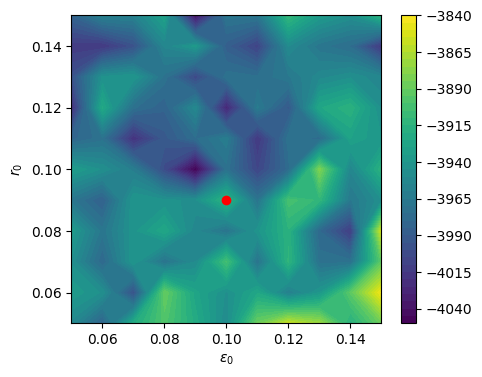

In [7]:
# Parameter ranges
eps_0_values = np.linspace(0.05, 0.15, 11)
r_0_values = np.linspace(0.05, 0.15, 11)

# Optimise parameters
optimize_parameters(J_matrix, eps_0_values, r_0_values)


## Use MLOOP to optimise the parameters

Based on the results provided by the previous scan

In [8]:
min_bound = [0.05, 0.05]
max_bound = [0.2, 0.2]
controller = mloop_optimize(J_matrix, min_bound, max_bound)
print(f'Best parameters found: {controller.best_params}')
print(f'Best cost found: {controller.best_cost}')

INFO     M-LOOP version 3.3.4
INFO     Optimization started.
INFO     Run: 0 (training)
INFO     params [0.05304367 0.15547985]
INFO     cost -3940.0 +/- 0.0
INFO     Run: 1 (training)
INFO     params [0.17624626 0.17476457]
INFO     cost -3886.0 +/- 0.0
INFO     Run: 2 (training)
INFO     params [0.07517863 0.18473795]
INFO     cost -3872.0 +/- 0.0
INFO     Run: 3 (training)
INFO     params [0.16984047 0.05842971]
INFO     cost -4004.0 +/- 0.0
INFO     Run: 4 (training)
INFO     params [0.09502901 0.06077042]
INFO     cost -3968.0 +/- 0.0
INFO     Run: 5 (training)
INFO     params [0.15797355 0.08419252]
INFO     cost -3952.0 +/- 0.0
INFO     Run: 6 (training)
INFO     params [0.16655779 0.12339196]
INFO     cost -3946.0 +/- 0.0
INFO     Run: 7 (training)
INFO     params [0.08093586 0.13035667]
INFO     cost -3894.0 +/- 0.0
INFO     Run: 8 (training)
INFO     params [0.07409603 0.15405518]
INFO     cost -3882.0 +/- 0.0
INFO     Run: 9 (training)
INFO     params [0.18209841 0.19706305]

# Convert Ising Energy to Max-Cut

In [12]:
E = -4058 
J = J_matrix
maxcut_energy = calculate_maxcut_energy(E, J)
print(f"Max-Cut Energy: {maxcut_energy}")


Max-Cut Energy: -11617.0


# Run Simulations Based on Optimised Parameters

In [10]:
# Define the parameters
eps_0 = 0.10611397
r_0 = 0.05

all_results = []
times_to_minimum = []

# Run the simulations
for _ in range(100):
    solve = CIM_AHC_GPU(T_time=40, 
                        J=J_matrix, 
                        batch_size=1, 
                        time_step=0.01, 
                        custom_fb_schedule=lambda ticks, time_step: custom_fb_schedule(ticks, time_step, eps_0), 
                        custom_pump_schedule=lambda ticks, time_step: custom_pump_schedule(ticks, time_step, r_0))
    energy_trace = solve[3]
    min_energy = np.min(energy_trace)
    min_index = np.argmin(energy_trace)
    all_results.append((min_energy, solve))
    times_to_minimum.append(min_index) 

# Calculate statistics
least_energy, best_run = min(all_results, key=lambda x: x[0])
mean_energy = np.mean([x[0] for x in all_results])
std_energy = np.std([x[0] for x in all_results])

# Print the results
print(f'Least energy found: {least_energy}')
print(f'Mean energy found: {mean_energy}')
print(f'Standard deviation of the energy: {std_energy}')


Least energy found: -4064.0
Mean energy found: -3974.820068359375
Standard deviation of the energy: 30.884424209594727


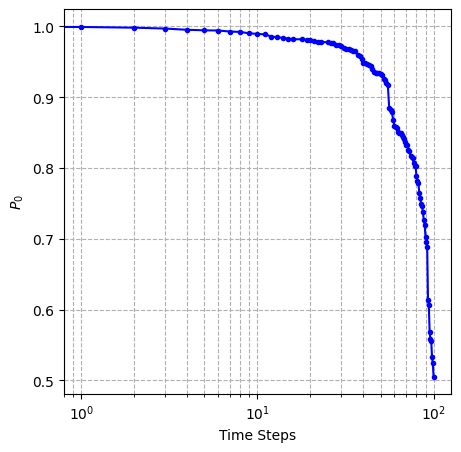

In [13]:
total_instances = 100  # Total number of instances
max_time_steps = int(40 / 0.01)  # Total number of time steps
not_reached_counts = [total_instances] * max_time_steps  # Start with all instances not reached
for t in times_to_minimum:
    not_reached_counts[t:] = [x - 1 for x in not_reached_counts[t:]]


unique_counts = {}  # Dictionary to store the first occurrence of each count
last_count = total_instances  # Start with the initial count of instances not reached
for time_step in range(max_time_steps):
    count = not_reached_counts[time_step]
    if count != last_count:
        if last_count not in unique_counts:
            unique_counts[last_count] = time_step - 1  # Store the last time step for the previous count
        last_count = count

# Include the last count occurrence
if last_count not in unique_counts:
    unique_counts[last_count] = max_time_steps - 1

# Extracting data for plotting
times, counts = zip(*sorted(unique_counts.items(), key=lambda x: x[1]))
percentages = [100 * count / (total_instances * int(40 / 0.01)) for count in counts]  # Convert counts to percentages

# Plotting
plt.figure(figsize=(5, 5))
plt.plot(times, percentages, marker='.', linestyle='-', color='blue')
plt.xlabel('Time Steps')
plt.ylabel(r'$P_0$')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.show()


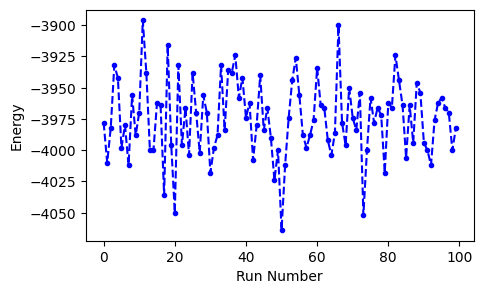

In [14]:
# Unpacking the data from the best run
spin_config, x_trajectory, t, energy_plot_data, error_var_data, divg, kappa = best_run

# Extract the lowest energy values from each run
lowest_energies = [result[0] for result in all_results]

# Create a figure for plotting
plt.figure(figsize=(5, 3))
plt.plot(lowest_energies, marker='.', linestyle='--', color = 'blue')
plt.xlabel('Run Number')
plt.ylabel('Energy')
plt.show()


## Check Simulation Results

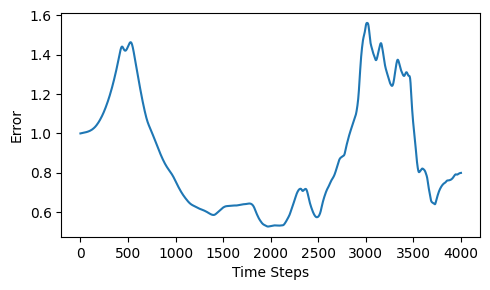

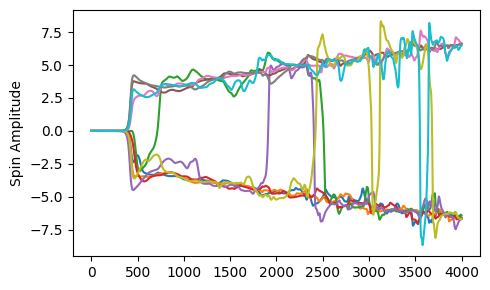

Energy reaches a steady state at: 3910
Max-Cut Energy: -11620.0


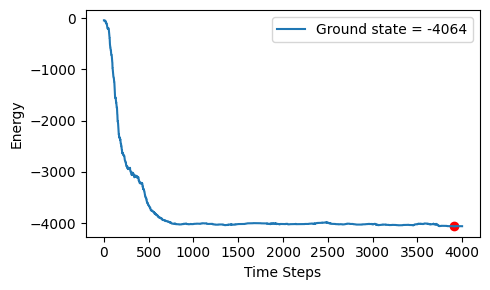

In [16]:
# Plotting the error over time
plt.figure(figsize=(5, 3))
plt.plot(error_var_data[0][0])
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

# # Plotting the divergence over time
# plt.figure(figsize=(5, 3))
# plt.plot(divg[0], label='Divergence')
# plt.xlabel('Time Steps')
# plt.ylabel('Divergence')
# plt.legend()
# plt.show()

# Plotting spin amplitude for each of the first 50 spins
plt.figure(figsize=(5, 3))
for spin_index in range(10):
    plt.plot(np.arange(t+1), x_trajectory[0, spin_index, :])
plt.ylabel('Spin Amplitude')
plt.tight_layout()
plt.show()

energy_trace = energy_plot_data[0]
min_energy = np.min(energy_trace)
# Find the index of the first occurrence of the minimum energy
first_min_index = np.where(energy_trace == min_energy)[0][0]

threshold = 10  # Define a small threshold value
period = 5  # Period to check for stability
if all(abs(energy_trace[first_min_index + i] - min_energy) < threshold for i in range(period)):
    print("Energy reaches a steady state at:", first_min_index)
else:
    print("Energy reaches the lowest value at:", first_min_index, "but doesn't remain stable for the next", period, "steps.")
maxcut_energy = calculate_maxcut_energy(min_energy, J)
print(f"Max-Cut Energy: {maxcut_energy}")
# Plotting the point where energy reaches steady state
plt.figure(figsize=(5, 3))
plt.plot(energy_trace, label=f'Ground state = {min_energy:.0f}')
plt.scatter(first_min_index, min_energy, color='red')  # Mark the steady state point
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.legend()
plt.tight_layout()
plt.show()
